In [80]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error

from airpollution_trf_graph_loader import AirpollutionDatasetLoader

In [81]:
T_lst= [12,24] #target time horizons to analyze
_city= 'madrid'
_include_trf= True # include or not traffic data as input

results_path='results'

loader= AirpollutionDatasetLoader(_city, _include_trf)
dataset=loader.get_dataset(T=T_lst[0])

feature_dim= loader.get_feature_dim()
feature_dim

480
trf [[ 86   0  14   5]
 [ 12   1   1   1]
 [139   0  12   1]
 [ 80   0  12   4]
 [ 21   0   0   2]
 [ 86   0   4   7]
 [ 28  16   3   2]
 [ 15   3   1   0]
 [ 91   2  14   2]
 [ 11   0   0   0]
 [ 10   0   0   1]
 [ 67   0   2   0]
 [ 70   0   1   1]]
ap0 [[0.3 1. ]]
ap1 [[ 0.2 45.   4.   1.   1. ]]
ap2 [[15.  9.]]
ap3 [[65.]]
trf [[ 77   8  10   4]
 [  0   0   1   0]
 [ 70   0   4   9]
 [105   0   8   4]
 [  8   0   1   4]
 [ 62   0   3   5]
 [ 21  15   0   0]
 [  9   0   3   1]
 [ 75   5  17   1]
 [  0   0   0   1]
 [  1   0   0   0]
 [ 50   0   0   0]
 [106   0   1   0]]
ap0 [[0.3 1. ]]
ap1 [[ 0.1 50.   6.   2.   1. ]]
ap2 [[8. 3.]]
ap3 [[67.]]
trf [[61  5 27  3]
 [ 5  0  1  1]
 [51  0  8  9]
 [87  0 10  9]
 [11  0  0  3]
 [76  1  4  2]
 [18 18  3  1]
 [ 9  2  1  3]
 [65  2 27  6]
 [ 2  0  0  0]
 [ 1  0  0  0]
 [38  0  1  2]
 [81  5  6  5]]
ap0 [[0.3 1. ]]
ap1 [[ 0.1 51.   3.   1.   1. ]]
ap2 [[8. 3.]]
ap3 [[66.]]
trf [[37  8 20  3]
 [ 4  0  0  0]
 [32  0  0  8]
 [72  1  0  4]
 

{'trf': 4, 'ap0': 2, 'ap1': 5, 'ap2': 2, 'ap3': 1}

In [82]:
target_nodes= list(feature_dim.keys())
target_nodes

['trf', 'ap0', 'ap1', 'ap2', 'ap3']

In [83]:
y_hat_dict= {}
y_true_dict= {}

for _trf_str in ['trf', 'no_trf']:    
    for _T in T_lst:
        for k in target_nodes:
            if (_trf_str !=  'no_trf') or (k != 'trf'):
                _df= pd.read_csv(os.path.join(results_path,f'y_hat_{_city}_{_T}_{k}_{_trf_str}.csv'), index_col=0)
                y_hat_dict['_'.join([str(_T),k,_trf_str])]= _df
            
                _df= pd.read_csv(os.path.join(results_path,f'y_true_{_city}_{_T}_{k}_{_trf_str}.csv'), index_col=0)
                y_true_dict['_'.join([str(_T),k,_trf_str])]= _df

In [84]:
y_true_dict

{'12_trf_trf':        Car  Motorcycle   Bus  Truck
 0     14.0         0.0   0.0    0.0
 1     85.0         0.0   8.0    2.0
 2     50.0         0.0   3.0    2.0
 3     21.0         1.0   0.0    0.0
 4    105.0         1.0   2.0    7.0
 ..     ...         ...   ...    ...
 177   60.0         0.0  21.0   11.0
 178   25.0         4.0   2.0   15.0
 179   48.0         1.0   2.0   30.0
 180    3.0         0.0   0.0    1.0
 181   71.0         2.0  15.0    9.0
 
 [182 rows x 4 columns],
 '12_ap0_trf':      CO  SO2
 0   0.7  2.0
 1   0.6  1.0
 2   0.5  1.0
 3   0.4  1.0
 4   0.4  1.0
 5   0.4  1.0
 6   0.3  1.0
 7   0.3  1.0
 8   0.4  1.0
 9   0.4  1.0
 10  0.6  3.0
 11  0.8  3.0
 12  0.7  3.0
 13  0.5  2.0,
 '12_ap1_trf':      CO    O3  PM10  PM25  SO2
 0   1.1   4.0  82.0  26.0  1.0
 1   1.3   4.0  65.0  22.0  1.0
 2   0.7   7.0  48.0  18.0  1.0
 3   0.2  45.0  34.0  17.0  1.0
 4   0.1  65.0  19.0  10.0  1.0
 5   0.1  52.0  24.0  12.0  1.0
 6   0.1  52.0  22.0  11.0  1.0
 7   0.1  52.0  16.0

In [85]:
def mape_fn(actual, pred):
    #print(actual)
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / (actual+0.01))) * 100

def compute_metrics_as_dataframe_fn(y_valid, y_hat, particle_name):
    metrics= []
    metrics_global = {'mse':[],'rmse':[],'mae':[],'cvrmse':[],'mape':[],}

    try:
        mae = mean_absolute_error(y_valid, y_hat)
        mse = mean_squared_error(y_valid, y_hat)
        rmse= mean_squared_error(y_valid, y_hat, squared = False)
        cvrmse =  (rmse/np.mean(y_valid))*100 # it is a percentage
        mape = mape_fn(y_valid, y_hat)

        metrics.append((time_horizon, str(particle_name), mae, mse, rmse, cvrmse, mape))


        metrics_df = pd.DataFrame.from_records(metrics, columns='T particle MAE MSE RMSE CVRMSE MAPE'.split())

        return metrics_df
    except:
        return None

def compute_metrics(y_valid, y_hat):
    metrics= []
    metrics_global = {'mse':[],'rmse':[],'mae':[],'cvrmse':[],'mape':[],}

    mae = mean_absolute_error(y_valid, y_hat)
    mse = mean_squared_error(y_valid, y_hat)
    rmse= mean_squared_error(y_valid, y_hat, squared = False)
    cvrmse =  (rmse/np.mean(y_valid))*100 # it is a percentage
    mape = mape_fn(y_valid, y_hat)

    return mae, mse, rmse, cvrmse, mape


In [86]:
metrics_by_sensors= []
metrics_by_pollutants= []
for _trf_str in ['trf', 'no_trf']:    
    for _T in T_lst:
        for k in target_nodes:
            if k != 'trf':
                y_true_df= y_true_dict['_'.join([str(_T),k,_trf_str])]
                y_hat_df= y_hat_dict['_'.join([str(_T),k,_trf_str])]
            
                #Metris by station
                for i in range(y_true_df.shape[0]):
                    mae, mse, rmse, cvrmse, mape= compute_metrics(y_true_df.iloc[i], y_hat_df.iloc[i])
                    #print(y_true_df, y_hat_df, mae, mse, rmse, cvrmse, mape)
                    metrics_by_sensors.append((_T, _trf_str, k, i, mae, mse, rmse, cvrmse, mape))
            
                for c in y_true_df.columns:
                    c_hat= y_hat_df[c].T
                    c_true= y_true_df[c].T
                    mae, mse, rmse, cvrmse, mape= compute_metrics(c_true, c_hat)
                    metrics_by_pollutants.append((_T, _trf_str, k, c, mae, mse, rmse, cvrmse, mape))


metrics_by_sensors_df = pd.DataFrame.from_records(metrics_by_sensors, columns='T traffic sensor t MAE MSE RMSE CVRMSE MAPE'.split())
metrics_by_pollutants_df = pd.DataFrame.from_records(metrics_by_pollutants, columns='T traffic sensor pollutant MAE MSE RMSE CVRMSE MAPE'.split())

  
metrics_by_sensors_df.to_csv(os.path.join(results_path,f'metrics_by_sensor_{_city}.csv'))
metrics_by_pollutants_df.to_csv(os.path.join(results_path,f'metrics_by_pollutant_{_city}.csv'))

### Metrics by sensor

In [87]:
metrics_by_sensors_df

,T,traffic,sensor,t,MAE,MSE,RMSE,CVRMSE,MAPE
0,12,trf,ap0,0,0.202258,0.042669,0.206565,15.301138,17.363389
1,12,trf,ap0,1,0.658709,0.704712,0.839472,104.933939,69.708617
2,12,trf,ap0,2,0.583861,0.623547,0.789650,105.286686,60.342036
3,12,trf,ap0,3,0.534926,0.542102,0.736276,105.182270,55.064253
4,12,trf,ap0,4,0.534926,0.542102,0.736276,105.182270,55.064253
...,...,...,...,...,...,...,...,...,...
211,24,no_trf,ap3,8,2.107834,4.442964,2.107834,2.702351,2.702005
212,24,no_trf,ap3,9,2.807583,7.882522,2.807583,4.679305,4.678525
213,24,no_trf,ap3,10,9.562103,91.433814,9.562103,43.464105,43.444357
214,24,no_trf,ap3,11,20.331203,413.357815,20.331203,225.902256,225.651532


12 hours horizon

In [88]:
metric_agg_mean_df= metrics_by_sensors_df[metrics_by_sensors_df['T']==12].groupby('sensor T traffic'.split()).mean()
metric_agg_mean_df

t        MAE         MSE       RMSE      CVRMSE  \
sensor T  traffic                                                      
ap0    12 no_trf   6.5   0.452331    0.381607   0.587274   72.509383   
          trf      6.5   0.480089    0.441540   0.630264   76.394754   
ap1    12 no_trf   6.5   8.016674  224.178746  12.202589   79.442805   
          trf      6.5   8.068352  224.357191  12.302394   79.598512   
ap2    12 no_trf   6.5   6.720467   97.223882   7.364445   32.169949   
          trf      6.5   6.957992  100.972647   7.606690   33.268944   
ap3    12 no_trf   6.5  22.199636  697.177483  22.199636  203.339779   
          trf      6.5  20.657699  628.224007  20.657699  194.101932   

                         MAPE  
sensor T  traffic              
ap0    12 no_trf    43.952944  
          trf       44.521546  
ap1    12 no_trf    90.821505  
          trf       83.113408  
ap2    12 no_trf    31.804565  
          trf       32.816099  
ap3    12 no_trf   203.090353  
          trf      193.860778

In [89]:
metric_agg_mean_df= metrics_by_sensors_df[metrics_by_sensors_df['T']==12].groupby('sensor T traffic t'.split()).mean().reset_index()
metric_agg_mean_df[metric_agg_mean_df['t']==0]

,sensor,T,traffic,t,MAE,MSE,RMSE,CVRMSE,MAPE
0,ap0,12,no_trf,0,0.200189,0.046526,0.215700,15.977767,15.419548
14,ap0,12,trf,0,0.202258,0.042669,0.206565,15.301138,17.363389
28,ap1,12,no_trf,0,23.641269,1117.751475,33.432790,146.506531,233.721959
42,ap1,12,trf,0,23.561602,1118.025995,33.436896,146.524521,225.947587
56,ap2,12,no_trf,0,25.069846,739.168609,27.187655,67.130013,60.858977
70,ap2,12,trf,0,25.187864,745.529037,27.304378,67.418216,61.177725
84,ap3,12,no_trf,0,38.790092,1504.671237,38.790092,431.001022,430.522664
98,ap3,12,trf,0,37.198006,1383.691650,37.198006,413.311178,412.852453


In [90]:
metric_agg_mean_df[metric_agg_mean_df['t']==6]

,sensor,T,traffic,t,MAE,MSE,RMSE,CVRMSE,MAPE
6,ap0,12,no_trf,6,0.544422,0.456204,0.675429,103.912108,70.074082
20,ap0,12,trf,6,0.538038,0.472534,0.687411,105.755564,65.589358
34,ap1,12,no_trf,6,3.188593,24.865338,4.986516,28.957698,66.662826
48,ap1,12,trf,6,3.547823,30.467937,5.519777,32.054453,55.111379
62,ap2,12,no_trf,6,1.214295,1.717648,1.310591,10.921589,9.834165
76,ap2,12,trf,6,1.005837,1.112544,1.054772,8.789765,8.429437
90,ap3,12,no_trf,6,6.083180,37.005079,6.083180,14.146930,14.143641
104,ap3,12,trf,6,4.034360,16.276061,4.034360,9.382233,9.380051


24 hours horizon

In [91]:
metric_agg_mean_df= metrics_by_sensors_df[metrics_by_sensors_df['T']==24].groupby('sensor T traffic'.split()).mean()
metric_agg_mean_df

t       MAE         MSE      RMSE     CVRMSE       MAPE
sensor T  traffic                                                           
ap0    24 no_trf   6.0  0.516830    0.486163  0.688334  95.252033  54.772894
          trf      6.0  0.538047    0.537366  0.720728  98.841549  55.579693
ap1    24 no_trf   6.0  3.888472   54.626063  5.900387  27.616442  62.935709
          trf      6.0  3.638585   44.777061  5.387950  25.227562  58.918561
ap2    24 no_trf   6.0  4.512078   39.900501  4.864435  33.595503  66.668911
          trf      6.0  4.135446   33.978222  4.531786  30.958725  59.663002
ap3    24 no_trf   6.0  8.079854  109.077083  8.079854  47.215279  47.166711
          trf      6.0  8.327625  115.167934  8.327625  49.873765  49.822755

## Metrics by pollutants

12 hours horizon

In [92]:
metric_agg_mean_df= metrics_by_pollutants_df[metrics_by_pollutants_df['T']==12].drop(columns='sensor').groupby('pollutant T traffic'.split()).mean()
metric_agg_mean_df

MAE         MSE       RMSE     CVRMSE        MAPE
pollutant T  traffic                                                         
CO        12 no_trf    0.187315    0.071327   0.228572  59.376131   73.652849
             trf       0.171132    0.068708   0.227137  58.763447   60.016396
O3        12 no_trf   21.033450  617.887736  24.805916  85.844137  215.885195
             trf      20.189954  573.906826  23.929453  82.688109  207.973185
PM10      12 no_trf   11.639427  345.247121  17.861252  58.366071   29.364490
             trf      11.997893  356.881574  18.165206  59.366045   30.451239
PM25      12 no_trf    4.884103   43.006794   6.504430  50.066157   34.658091
             trf       5.024508   45.099769   6.659075  51.254457   35.434371
SO2       12 no_trf    0.570005    0.428118   0.593524  43.553681   50.795822
             trf       0.554324    0.462291   0.580056  41.009722   48.176362

24 hours horizon

In [93]:
metric_agg_mean_df= metrics_by_pollutants_df[metrics_by_pollutants_df['T']==24].drop(columns='sensor').groupby('pollutant T traffic'.split()).mean()
metric_agg_mean_df

MAE         MSE       RMSE     CVRMSE       MAPE
pollutant T  traffic                                                       
CO        24 no_trf   0.112299    0.021413   0.133884  34.435790  47.495532
             trf      0.109792    0.019153   0.127174  32.702255  48.015912
O3        24 no_trf   7.948423  123.471411  11.092811  17.253681  80.506356
             trf      7.840425  111.060837  10.536738  16.357930  73.788276
PM10      24 no_trf   6.509390   90.000498   9.334316  31.212193  20.597401
             trf      5.978632   77.015522   8.639245  28.903183  18.355224
PM25      24 no_trf   3.605230   17.472419   4.152713  46.169987  97.627301
             trf      3.376456   15.376269   3.911022  43.351595  90.490490
SO2       24 no_trf   0.614673    0.524623   0.635241  54.306408  56.137843
             trf      0.628464    0.570428   0.650672  55.372067  56.800575

## Plot forecasted vs real values

In [94]:
T_to_plot='24'
y_true_lst={}
y_hat_lst={}
for k,df in y_true_dict.items():
    y_hat_df= y_hat_dict[k]
    if (T_to_plot in k) and ('no_trf' in k):
        for c in df.columns:
            df_lst= y_true_lst.get(c,[])
            df_lst.append(df[c].to_frame().reset_index())
            y_true_lst[c]= df_lst

            df_lst= y_hat_lst.get(c,[])
            df_lst.append(y_hat_df[c].to_frame().reset_index())
            y_hat_lst[c]= df_lst

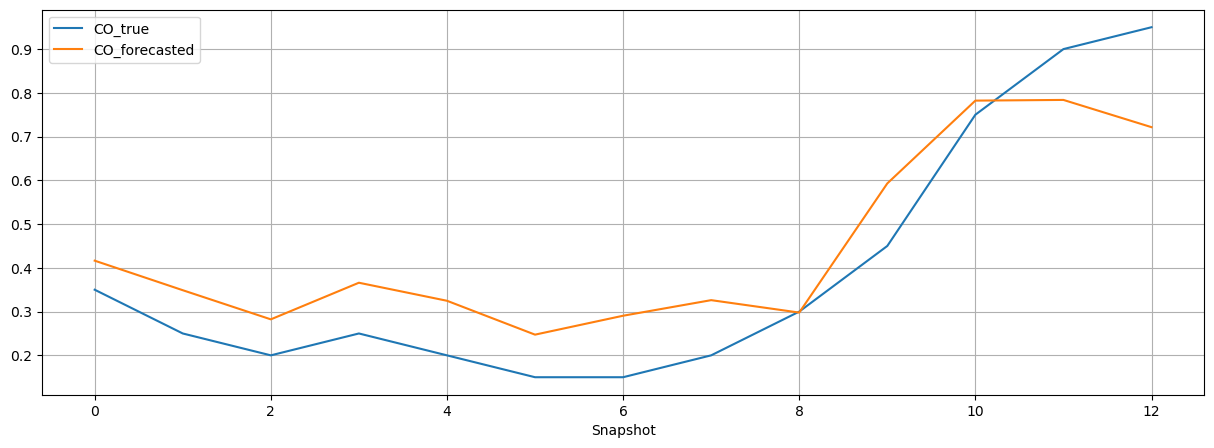

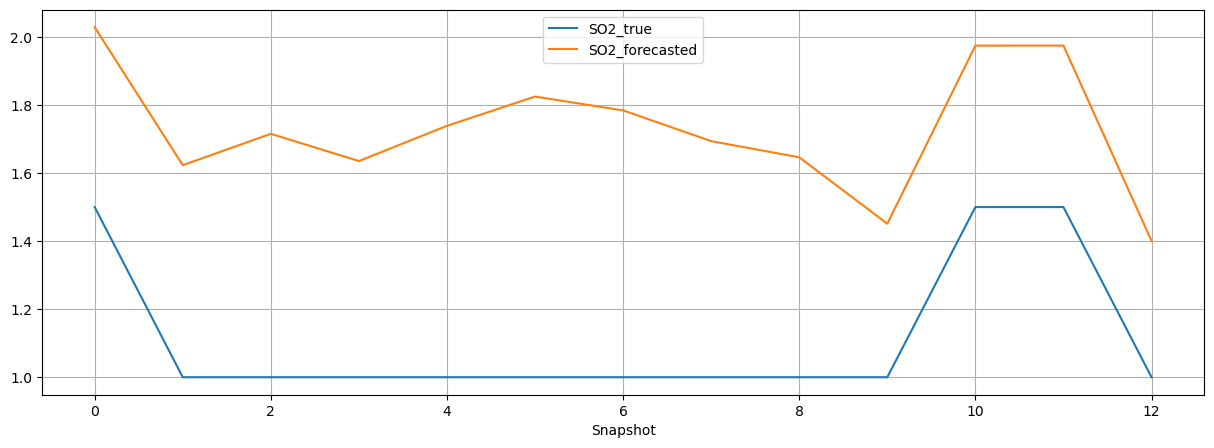

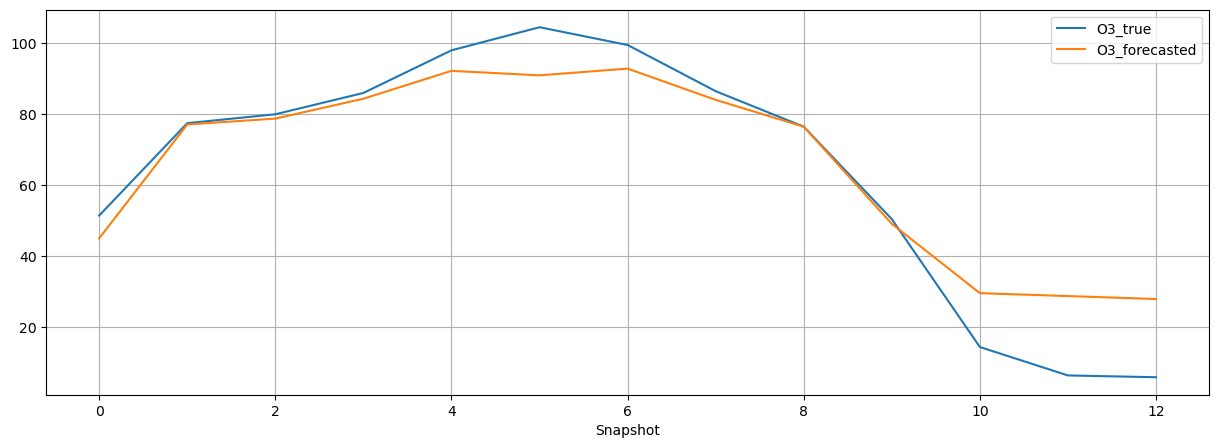

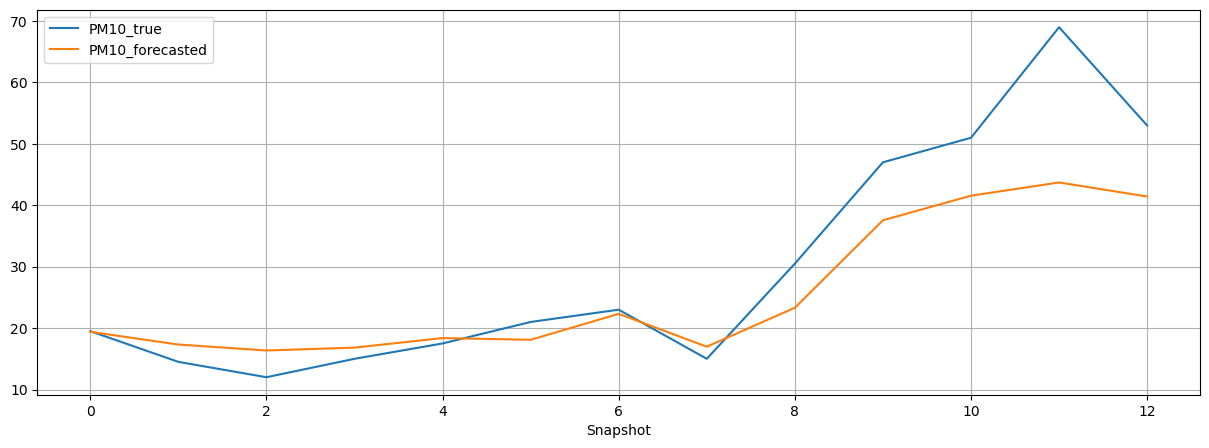

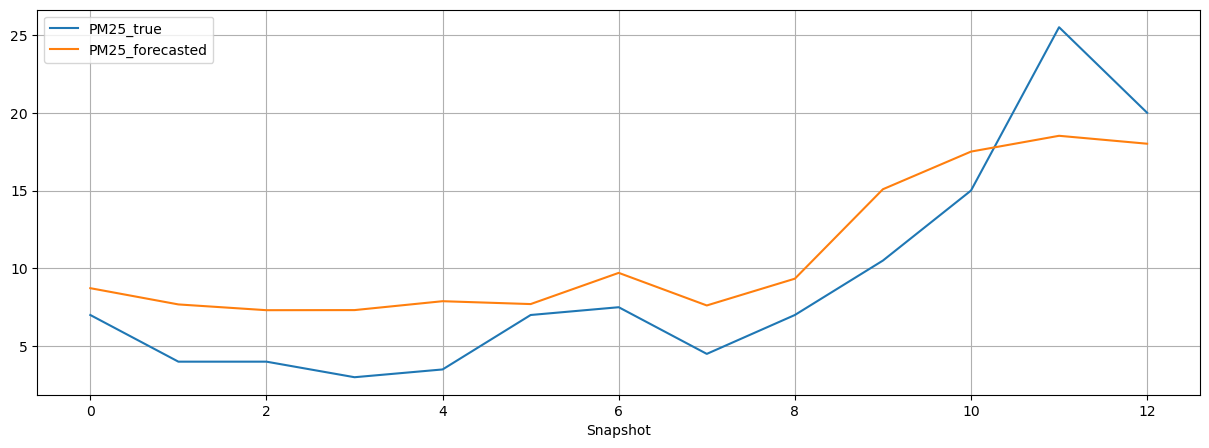

In [95]:
_trf_str= 'trf'
if not _include_trf:
    _trf_str='no_trf'

for k, lst in y_true_lst.items():
    
    df= pd.concat(lst, axis=0)
    df= df.groupby('index').mean()
    df= df.rename(columns={k:f'{k}_true'})

    lst2= y_hat_lst[k]
    y_hat_df= pd.concat(lst2, axis=0)
    y_hat_df= y_hat_df.groupby('index').mean()
    y_hat_df= y_hat_df.rename(columns={k:f'{k}_forecasted'})
    
    ax=df.plot(grid=True, figsize=(15,5));
    y_hat_df.plot(ax=ax, grid=True, xlabel='Snapshot');
    

    plt.savefig(os.path.join(os.path.join('figs', f'true_vs_forecast_{k}_{T_to_plot}_{_city}_{_trf_str}.png')), bbox_inches='tight')

In [96]:
print("That's all folks!")

That's all folks!
